## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [132]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

In [133]:
using DelimitedFiles

Load some packages to make nice figures

In [134]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [281]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [282]:
Δtdyn = 0.05
Δtobs = 0.05

0.05

Define the time span of interest

In [283]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

2000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [284]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [285]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [286]:
### Process and observation noise
σx = 1e-1
σy = 1.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])

In [287]:
ϵx.Σ

3×3 Diagonal{Float64,Array{Float64,1}}:
 0.01   ⋅     ⋅ 
  ⋅    0.01   ⋅ 
  ⋅     ⋅    0.01

In [288]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [289]:
# Number of runs
Ne = 500

# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 3-element Array{Float64,1}:
 0.0
 0.0
 0.0

Create cache to store the different final solutions

In [290]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

Set initial condition of the true system

In [291]:
x0 = rand(model.π0);

In [292]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [293]:
Ne = 500 #ensemble size
Xenkf = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(Xenkf, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×500 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  1.13052   -0.546509  -1.04313   …  -1.64599    0.458997  -0.682553
 -0.294152   0.438442  -0.746536      0.622083   0.612457  -0.454435
 -0.329373   0.32153    0.201858     -0.20027   -0.52896   -0.400865

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [294]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)
tspin = 10.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

200

In [295]:
Xspin = seqassim(F, data, Tspin, model.ϵx, enkf, deepcopy(Xenkf), model.Ny, model.Nx, t0);

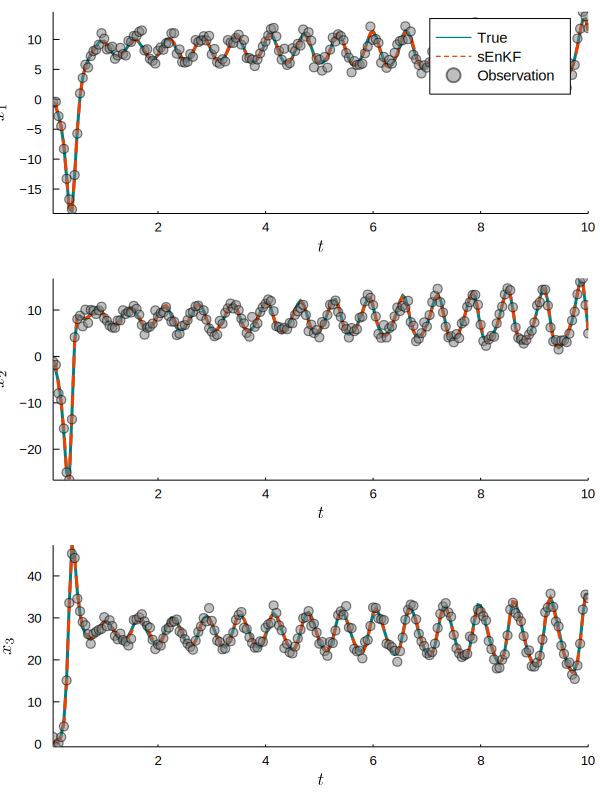

In [296]:
nb = 1
ne = Tspin
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)),
         legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xspin)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

In [297]:
rmse = norm(data.xt[:,100]-mean(Xspin[end]; dims = 2)[:,1])/sqrt(Nx)

7.289522970242774

In [298]:
X = vcat(zeros(Ny, Ne), Xspin[end])

6×500 Array{Float64,2}:
  0.0      0.0       0.0       0.0      …   0.0       0.0       0.0
  0.0      0.0       0.0       0.0          0.0       0.0       0.0
  0.0      0.0       0.0       0.0          0.0       0.0       0.0
 11.2948  10.9106   11.2309   11.8635      11.526    11.5108   11.4046
  5.0547   5.00695   5.27815   6.40729      5.77043   6.00657   5.845
 35.9743  35.9253   35.994    36.3373   …  36.497    36.2835   35.8669

In [299]:
prob = ODEProblem(F.f, zeros(Nx), (tspin, tspin + Δtobs))

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (10.0, 10.05)
u0: 3-element Array{Float64,1}:
 0.0
 0.0
 0.0

In [300]:
prob_func(prob,i,repeat) = ODEProblem(prob.f, X[Ny+1:Ny+Nx,i],prob.tspan)

ensemble_prob = EnsembleProblem(prob,output_func = (sol,i) -> (sol[end], false),
prob_func=prob_func)
sim = solve(ensemble_prob, Tsit5(), EnsembleThreads(),trajectories = Ne,
            dense = false, save_everystep=false);

@inbounds for i=1:Ne
    X[Ny+1:Ny+Nx, i] .= deepcopy(sim[i])
end

In [301]:
X

6×500 Array{Float64,2}:
  0.0       0.0       0.0       0.0      …   0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  8.0287    7.80903   8.07157   8.77422      8.35386   8.4506    8.3785
  1.66881   1.75556   1.85259   2.38881      1.93731   2.21379   2.29732
 32.9223   32.8453   33.0323   33.8473   …  33.6527   33.5966   33.1985

In [302]:
J = 1
n0 = ceil(Int64, tspin/Δtobs) + 1
Acycle = n0:n0+J-1
i=1

ystar = data.yt[:,Acycle[i]]

3-element Array{Float64,1}:
  8.306885381021859
  2.7831761780044895
 32.394077428832475

In [303]:
data.tt[201]

10.05

In [304]:
data.yt[:,201]

3-element Array{Float64,1}:
  8.306885381021859
  2.7831761780044895
 32.394077428832475

In [305]:
ϵx(X, Ny+1, Ny+Nx)

In [306]:
X

6×500 Array{Float64,2}:
  0.0       0.0       0.0       0.0      …   0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  7.97543   7.85879   8.03361   8.6194       8.30807   8.26851   8.44061
  1.74479   1.87065   1.89859   2.27838      1.97701   2.17549   2.21215
 33.0843   32.7938   32.8794   33.7606   …  33.4484   33.6556   33.0911

In [307]:
observe(F.h, X, tspin+1*Δtobs, Ny, Nx)

In [308]:
X

6×500 Array{Float64,2}:
  7.97543   7.85879   8.03361   8.6194   …   8.30807   8.26851   8.44061
  1.74479   1.87065   1.89859   2.27838      1.97701   2.17549   2.21215
 33.0843   32.7938   32.8794   33.7606      33.4484   33.6556   33.0911
  7.97543   7.85879   8.03361   8.6194       8.30807   8.26851   8.44061
  1.74479   1.87065   1.89859   2.27838      1.97701   2.17549   2.21215
 33.0843   32.7938   32.8794   33.7606   …  33.4484   33.6556   33.0911

In [309]:
# Perturbation of the measurements
ϵy(X, 1, Ny)

In [310]:
X

6×500 Array{Float64,2}:
  7.88386   8.14515   7.13264   9.04783  …   9.76573   6.17828   9.68088
  1.66029   2.46079   1.09648   3.43565      2.0707    2.19632  -0.227894
 33.2625   32.0032   34.3541   32.4712      32.9749   34.1891   32.6083
  7.97543   7.85879   8.03361   8.6194       8.30807   8.26851   8.44061
  1.74479   1.87065   1.89859   2.27838      1.97701   2.17549   2.21215
 33.0843   32.7938   32.8794   33.7606   …  33.4484   33.6556   33.0911

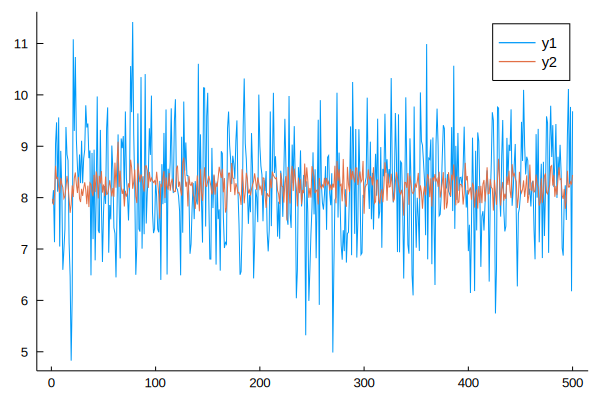

In [311]:
plot(X[1,:])
plot!(X[4,:])

In [322]:
M = totalordermap(X, 1; b = "CstLinProHermite")

Hermite map of dimension 6:
Map component of dimension 1 with Nψ = 1 active features
Map component of dimension 2 with Nψ = 2 active features
Map component of dimension 3 with Nψ = 3 active features
Map component of dimension 4 with Nψ = 4 active features
Map component of dimension 5 with Nψ = 5 active features
Map component of dimension 6 with Nψ = 6 active features


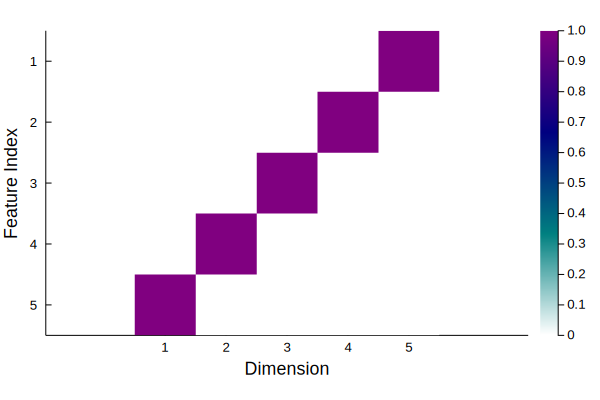

In [326]:
plot(M[5].I.f)

In [327]:
std.(eachslice(X; dims = 1))

6-element Array{Float64,1}:
 1.0373075405912402
 1.0675118439523428
 1.0233580628090193
 0.2306385971279051
 0.31340308135521955
 0.28744587241683167

In [328]:
optimize(M, X, nothing; withqr = true, apply_rescaling = true,
	     verbose = true, start = Ny+1, P = serial, hessprecond = true)

error = 1.3620542711845238
error = 1.2129160955013794
error = 1.0597268376388882


Hermite map of dimension 6:
Map component of dimension 1 with Nψ = 1 active features
Map component of dimension 2 with Nψ = 2 active features
Map component of dimension 3 with Nψ = 3 active features
Map component of dimension 4 with Nψ = 4 active features
Map component of dimension 5 with Nψ = 5 active features
Map component of dimension 6 with Nψ = 6 active features


In [329]:
# M[6].I.f.coeff .= [1.0; 0.0; 0.0; 0.0; 0.0; 0.0]

In [330]:
getcoeff(M[6])

6-element Array{Float64,1}:
  0.7643257504640155
  0.6129458244841431
 -1.097706709922831
 -0.22772277537841956
  0.003605853822937543
  0.00096968857347597

In [331]:
evaluate(M, X[:,1:1]; apply_rescaling = true)[6,1]

-0.33360552813906796

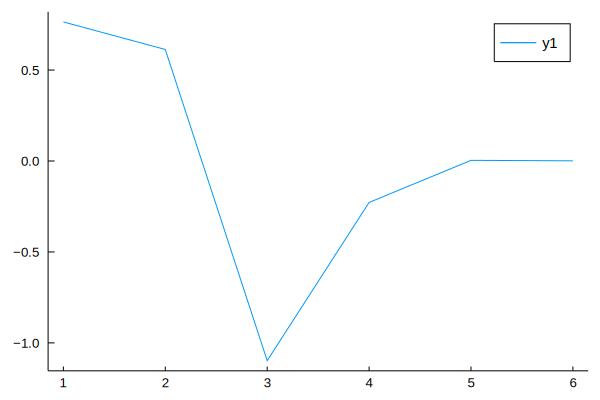

In [332]:
plot(getcoeff(M[6]))

In [333]:
X

6×500 Array{Float64,2}:
  7.88386   8.14515   7.13264   9.04783  …   9.76573   6.17828   9.68088
  1.66029   2.46079   1.09648   3.43565      2.0707    2.19632  -0.227894
 33.2625   32.0032   34.3541   32.4712      32.9749   34.1891   32.6083
  7.97543   7.85879   8.03361   8.6194       8.30807   8.26851   8.44061
  1.74479   1.87065   1.89859   2.27838      1.97701   2.17549   2.21215
 33.0843   32.7938   32.8794   33.7606   …  33.4484   33.6556   33.0911

In [334]:
Mxpush = deepcopy(evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial))

6×500 Array{Float64,2}:
  0.0        0.0        0.0       …   0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
 -1.04419   -1.55601   -0.707149      0.0582828  0.417037   1.13817
 -0.218505   0.150276   0.576297     -0.364231   0.737414   0.853526
 -0.333606  -0.696699  -1.57647   …   0.418422   1.75431   -1.45883

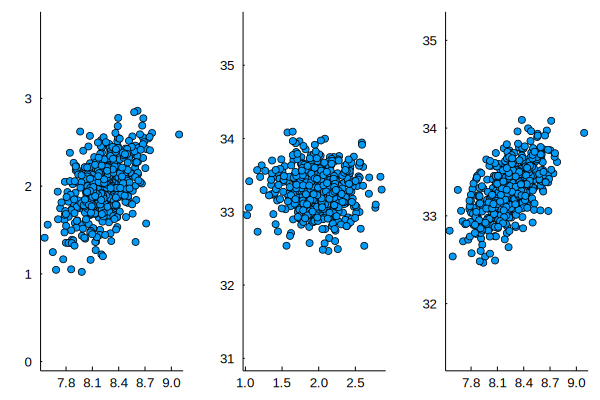

In [335]:
plt = plot(layout = grid(1,3), legend = false)
    scatter!(plt[1,1], X[4,:], X[5,:], ratio = 1)
    scatter!(plt[1,2], X[5,:], X[6,:], ratio = 1)
    scatter!(plt[1,3], X[4,:], X[6,:], ratio = 1)
plt

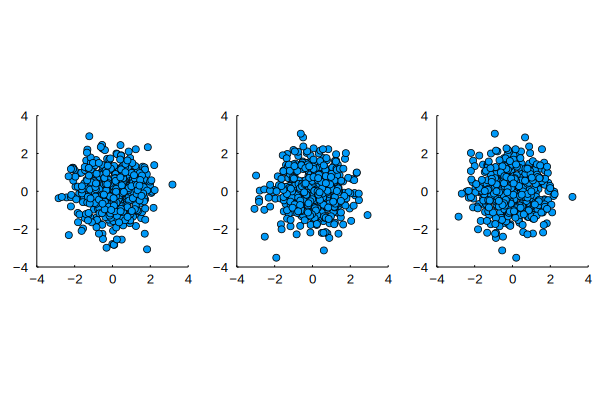

In [336]:
plt = plot(layout = grid(1,3), xlim = (-4, 4), ylim = (-4,4), legend = false)
    scatter!(plt[1,1], Mxpush[4,:], Mxpush[5,:], ratio = 1)
    scatter!(plt[1,2], Mxpush[5,:], Mxpush[6,:], ratio = 1)
    scatter!(plt[1,3], Mxpush[4,:], Mxpush[6,:], ratio = 1)
plt

In [337]:
ystar .-= view(M.L.μ,1:Ny)
ystar ./= M.L.L.diag[1:Ny]

3-element Array{Float64,1}:
  0.07029799817714283
  0.7723205315948728
 -0.8648202994722771

In [338]:
Xpost = deepcopy(X)

6×500 Array{Float64,2}:
  7.88386   8.14515   7.13264   9.04783  …   9.76573   6.17828   9.68088
  1.66029   2.46079   1.09648   3.43565      2.0707    2.19632  -0.227894
 33.2625   32.0032   34.3541   32.4712      32.9749   34.1891   32.6083
  7.97543   7.85879   8.03361   8.6194       8.30807   8.26851   8.44061
  1.74479   1.87065   1.89859   2.27838      1.97701   2.17549   2.21215
 33.0843   32.7938   32.8794   33.7606   …  33.4484   33.6556   33.0911

In [339]:
inverse!(Xpost, copy(Mxpush), M, ystar; start = Ny+1, P = serial, apply_rescaling = true)

6×500 Array{Float64,2}:
  0.070298   0.070298   0.070298  …   0.070298   0.070298   0.070298
  0.772321   0.772321   0.772321      0.772321   0.772321   0.772321
 -0.86482   -0.86482   -0.86482      -0.86482   -0.86482   -0.86482
  6.30416    6.19264    6.37759       6.54437    6.62254    6.77966
  1.76898    1.7906     2.01939       1.88783    2.21958    2.35125
 29.9563    29.7684    29.6787    …  30.29      30.5026    29.9561

In [340]:
data.xt[:,201]

3-element Array{Float64,1}:
  8.435589773305827
  2.0968910267841268
 33.06847290332517

In [341]:
evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial)

6×500 Array{Float64,2}:
  0.0        0.0        0.0       …   0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
 -1.04419   -1.55601   -0.707149      0.0582828  0.417037   1.13817
 -0.218505   0.150276   0.576297     -0.364231   0.737414   0.853526
 -0.333606  -0.696699  -1.57647   …   0.418422   1.75431   -1.45883

In [342]:
evaluate(M, vcat(repeat(ystar, 1, Ne), Xpost[Ny+1:Ny+Nx,:]); apply_rescaling = true, start = Ny+1, P = serial)

6×500 Array{Float64,2}:
  0.0        0.0        0.0       …   0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
  0.0        0.0        0.0           0.0        0.0        0.0
 -1.04419   -1.55601   -0.707149      0.0582828  0.417037   1.13817
 -0.218505   0.150276   0.576297     -0.364231   0.737414   0.853526
 -0.333606  -0.696699  -1.57647   …   0.418422   1.75431   -1.45883

In [343]:
norm(evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial) - evaluate(M, vcat(repeat(ystar, 1, Ne), Xpost[Ny+1:Ny+Nx,:]); apply_rescaling = true, start = Ny+1, P = serial))/norm(evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial))

3.5387418904734034e-15

In [344]:
Xpost

6×500 Array{Float64,2}:
  0.070298   0.070298   0.070298  …   0.070298   0.070298   0.070298
  0.772321   0.772321   0.772321      0.772321   0.772321   0.772321
 -0.86482   -0.86482   -0.86482      -0.86482   -0.86482   -0.86482
  6.30416    6.19264    6.37759       6.54437    6.62254    6.77966
  1.76898    1.7906     2.01939       1.88783    2.21958    2.35125
 29.9563    29.7684    29.6787    …  30.29      30.5026    29.9561

In [345]:
mean(Xpost; dims = 2)

6×1 Array{Float64,2}:
  0.07029799817714245
  0.7723205315948718
 -0.864820299472284
  6.531668851577945
  1.9724830147133687
 30.16069123737007

In [346]:
data.xt[:,201]

3-element Array{Float64,1}:
  8.435589773305827
  2.0968910267841268
 33.06847290332517

In [347]:
norm(mean(Xpost[4:end,:]; dims = 2)-data.xt[:,201])/sqrt(Nx)

2.007949737628342

Define the stochastic map filter `smf`, based on the `HermiteMap` `S`. 

In [103]:
X0 = vcat(zeros(Ny, Ne), Xspin[end])

# Add process noise
model.ϵx(X0, Ny+1, Ny+Nx)

# Generate the observations
observe(h, X0, tspin, Ny, Nx)

# Apply the observation noise
ϵy(X0, 1, Ny)

In [192]:
# m = 40
# S = HermiteMap(m, X0; diag = true, b = "CstLinProHermite")

S = totalordermap(X0, 2; b = "CstProHermite")

LoadError: [91mUndefVarError: X0 not defined[39m

In [193]:
# @time optimize(S, X0, "kfolds"; withqr = true, verbose = true, hessprecond = true, start = Ny+1)
@time optimize(S, X0, nothing; withqr = true, verbose = true, hessprecond = true, start = Ny+1)

LoadError: [91mUndefVarError: S not defined[39m

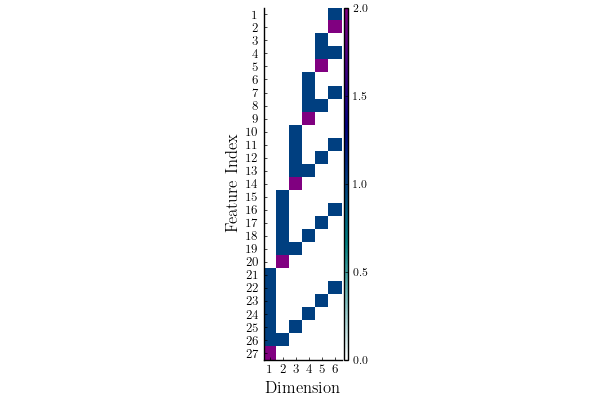

In [127]:
plot(S[6].I.f)

In [191]:
smf = FixedOrderStochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, false)

LoadError: [91mUndefVarError: S not defined[39m

In [129]:
mean(evaluate(S, X0; start = Ny+1); dims = 2)

6×1 Matrix{Float64}:
  0.0
  0.0
  0.0
 -0.00048330225574446994
 -0.004491294934531196
 -0.002129227728331044

In [130]:
cov(evaluate(S, X0; start = Ny+1); dims = 2)

6×6 Matrix{Float64}:
 0.0  0.0  0.0   0.0           0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0
 0.0  0.0  0.0   1.00199      -0.00020889  -0.000105526
 0.0  0.0  0.0  -0.00020889    1.00196      5.97084e-6
 0.0  0.0  0.0  -0.000105526   5.97084e-6   1.00174

In [131]:
Sxpush = evaluate(S, X0; start = Ny+1)[Ny+1:end,:]

3×500 Matrix{Float64}:
 -0.791481   0.122902  -0.251349  …  -1.6784     -0.771095   -0.764755
  0.60731   -1.0725     1.55565       1.30211     0.691928   -0.0538081
  0.799985  -0.247175   0.510229     -0.0322669  -0.0151946   1.99358

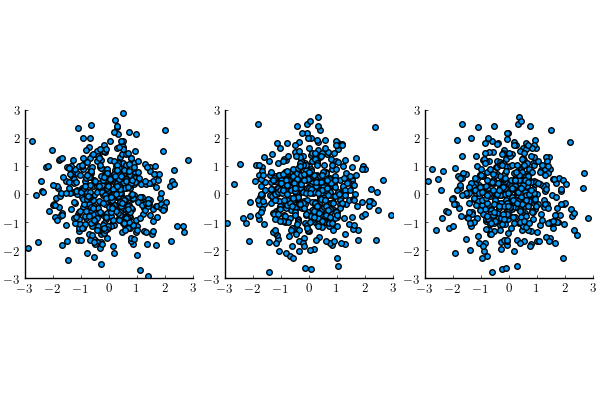

In [132]:
plt = plot(layout = grid(1,3), xlim = (-3, 3), ylim = (-3,3), legend = false)
    scatter!(plt[1,1], Sxpush[1,:], Sxpush[2,:], ratio = 1)
    scatter!(plt[1,2], Sxpush[2,:], Sxpush[3,:], ratio = 1)
    scatter!(plt[1,3], Sxpush[1,:], Sxpush[3,:], ratio = 1)
plt

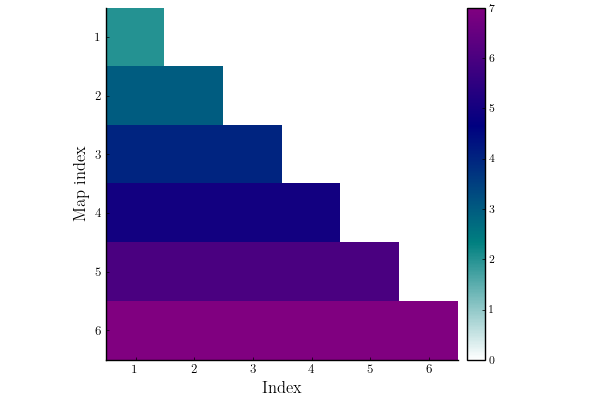

In [133]:
plot(S)

In [135]:
smf.M[6].I.f.B

MultiBasis(Basis of 5 functions: Constant, Linear, 0th -> 2th degree Probabilistic Hermite function
, 6)

In [115]:
Xsmf = seqassim(F, data, 100, model.ϵx, smf, deepcopy(vcat(zeros(Ny, Ne), Xspin[end])), model.Ny, model.Nx, tspin)

mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.0009617455083014071; 0.011040622946693685; -0.005110049925306835]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.994021154780508 0.16080024962646214 0.13947073291882536; 0.0 0.0 0.0 0.16080024962646214 0.9941181274573683 0.06929550891232279; 0.0 0.0 0.0 0.13947073291882536 0.06929550891232279 0.9940435431306266]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.0006034231134254587; 0.0005454118893176749; -0.011232463110513067]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9791922425119945 0.27161550443248156 0.38389299193304305; 0.0 0.0 0.0 0.27161550443248156 0.9976374483154492 0.07215128827447814; 0.0 0.0 0.0 0.38389299193304305 0.07215128827447814 0.9858143322176076]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.

mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.004853845275509628; 0.015100693575692778; -0.030712430422415907]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9737215546596044 0.6489135298444608 0.5481274169231223; 0.0 0.0 0.0 0.6489135298444608 0.9908159142323496 0.009236750996475713; 0.0 0.0 0.0 0.5481274169231223 0.009236750996475713 0.9714753225249001]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.0058282746840267585; 0.003197984970175319; -0.01793482274919866]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9861385826218865 0.6900465663674272 0.6043508026075742; 0.0 0.0 0.0 0.6900465663674272 0.9744676440608814 0.11158358047306975; 0.0 0.0 0.0 0.6043508026075742 0.11158358047306975 0.9907861428647414]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 

mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; 0.0006873880767514304; 0.008356227114803967; -0.028635405790876374]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9561183371362927 0.8477754084315993 0.28376681115474617; 0.0 0.0 0.0 0.8477754084315993 0.9657706982575833 -0.0388933203582712; 0.0 0.0 0.0 0.28376681115474617 -0.0388933203582712 0.9650491656832597]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.01756604160021815; -0.009415131700175496; -0.039488761600265085]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9692678876718971 0.8710447781068371 0.684056077336263; 0.0 0.0 0.0 0.8710447781068371 0.9314116412918536 0.4773042388752634; 0.0 0.0 0.0 0.684056077336263 0.4773042388752634 0.9590901525614363]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0;

mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.0051114722045417105; 0.011081853531275243; -0.018368154117557833]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9472050320148149 0.15389847870902104 0.6148127589495986; 0.0 0.0 0.0 0.15389847870902104 0.9933626996152343 -0.5242051752141289; 0.0 0.0 0.0 0.6148127589495986 -0.5242051752141289 0.9586485959757113]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; 0.00955390872511588; 0.02290753552452436; -0.025133455064833412]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.970130707266773 0.5604241799146714 0.1446482321846116; 0.0 0.0 0.0 0.5604241799146714 0.9742209522924405 -0.6089772806678909; 0.0 0.0 0.0 0.1446482321846116 -0.6089772806678909 0.9508322044252401]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0

mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.04753340889279552; -0.04196099410041648; -0.02860021390477097]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9339709995908103 0.13919266088902818 0.6948751635231135; 0.0 0.0 0.0 0.13919266088902818 0.9736812191134011 -0.39877016051552955; 0.0 0.0 0.0 0.6948751635231135 -0.39877016051552955 0.9140371877018272]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.03949089590684529; -0.02249680968486443; -0.016499357671887958]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9447218381922382 0.4437368446077935 0.4403461537500512; 0.0 0.0 0.0 0.4437368446077935 0.9723921292563023 -0.43519200212577835; 0.0 0.0 0.0 0.4403461537500512 -0.43519200212577835 0.9744951842883548]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0;

mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.019590274053699997; -0.01910035801977571; -0.01967699134764041]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9864157986368901 0.8887637881864394 0.6636432969886106; 0.0 0.0 0.0 0.8887637881864394 0.9908131857326703 0.41345035055674906; 0.0 0.0 0.0 0.6636432969886106 0.41345035055674906 0.9741402417949968]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0; -0.016352905225202923; -0.019630142166152106; -0.023680325366752197]
cov(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.9883450734566207 0.8910905467799187 0.8418570465024926; 0.0 0.0 0.0 0.8910905467799187 0.9624869024370917 0.6751422816375126; 0.0 0.0 0.0 0.8418570465024926 0.6751422816375126 0.9769866230220046]
mean(evaluate(M, X; start = Ny + 1); dims = 2) = [0.0; 0.0; 0.0;

101-element Vector{Matrix{Float64}}:
 [8.105935200149387 8.115892973340541 … 8.145539467985957 7.984111349639212; 9.162397430970314 9.182847194325628 … 9.183884406657192 9.295472019405116; 25.21677103621284 25.12372591392586 … 25.217395240507933 25.201164734988716]
 [8.667760840494848 8.559568395302726 … 8.506399280896938 8.583993848672845; 9.659383587943204 9.949858688488332 … 9.862185904015027 9.788340238202668; 25.89113830042545 25.859177753961575 … 25.872046309156083 25.92853613457949]
 [9.155970385615339 9.1091492175699 … 9.177907758232141 9.297324925098211; 10.109515529636724 10.214904042621692 … 10.09229218179791 9.944515457696612; 26.893747015238212 26.924306700973155 … 26.7996948789368 26.688379208513755]
 [9.629108290118584 9.5682619674103 … 9.589973514686337 9.55442024032533; 9.89788775418625 9.958686046461676 … 9.746303586244986 9.800541191497171; 27.850662922611907 28.140920108714866 … 28.017230743119793 27.979639651528924]
 [9.71406304187771 9.465492029912715 … 9.73020925

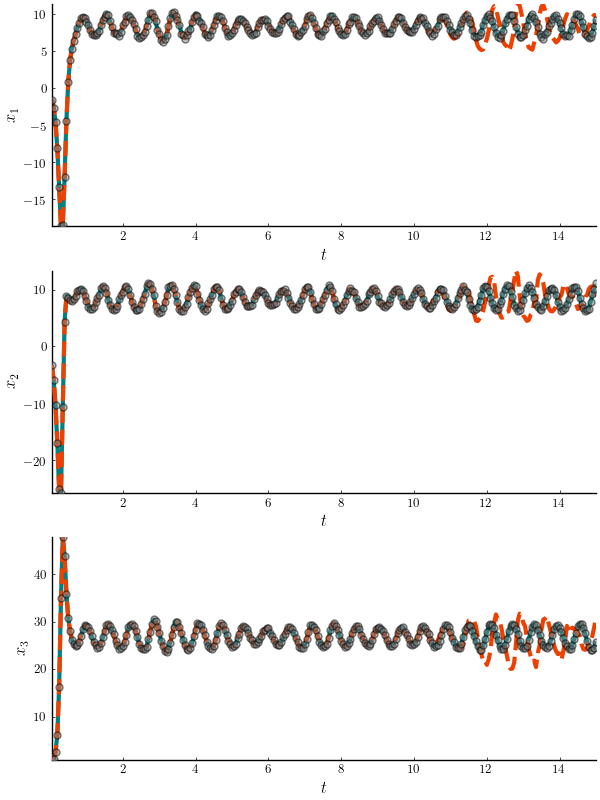

In [116]:
nb = 1
ne = Tspin+100
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = false, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xspin, Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

# savefig("lorenz63_kfoldoptim.pdf")

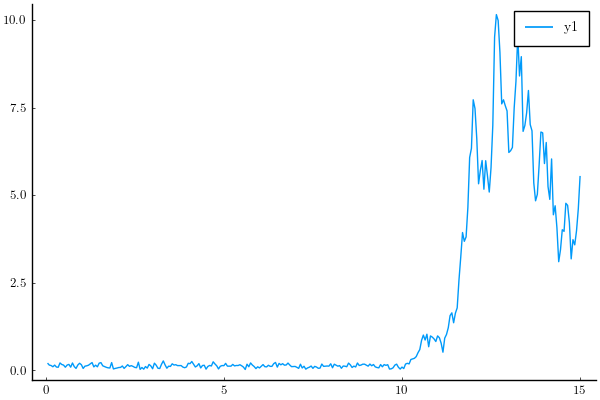

In [117]:
plot(data.tt[nb:Δ:ne], norm.(eachcol(mean_hist(vcat(Xspin, Xsmf[2:end]))[:,1+nb:Δ:1+ne]-data.xt[:,nb:Δ:ne])))

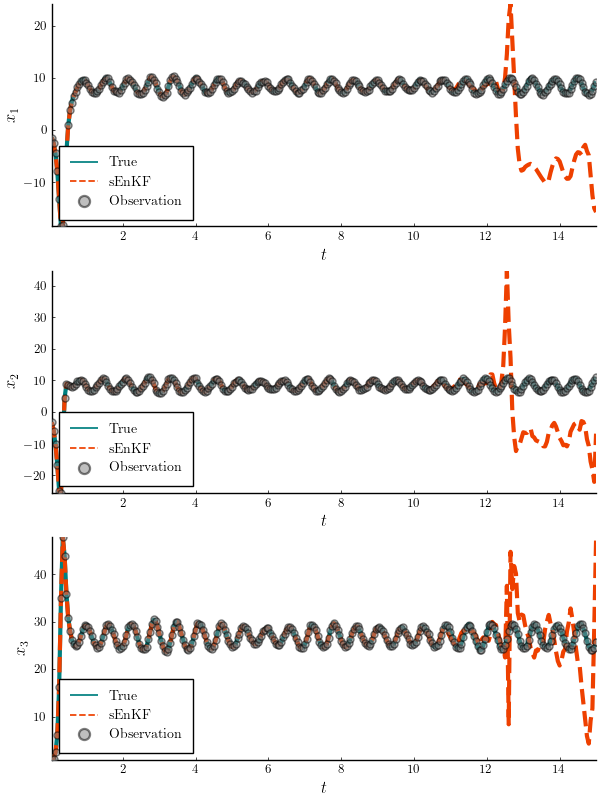

In [73]:
nb = 1
ne = Tspin+100
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xspin, Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

# savefig("lorenz63.pdf")

In [77]:
vcat(Xspin, Xsmf)

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [133]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3×101 Array{Float64,2} at index [1, 2:1:500][39m

In [69]:
Xsmf

┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/statespace/system.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/statespace/system.jl:4", UndefVarError(:TYPEDEF), Any[(top-level scope at system.jl:4, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/DA/inflation.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/DA/inflation.jl:52", UndefVarError(:TYPEDFIELDS), Any[(top-level scope at inflation.jl:52, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/enkf/etkf.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/enkf/etkf.jl:3", UndefVarError(:TYPEDSIGNATURES), Any[(top-level scope at etkf.jl:3, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Erro

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.